<table style="border: none" align="left">
   <tr style="border: none">
      <th style="text-align: left;border: none"><font face="verdana" size="5" color="black"><b>Train and deploy a heart disease prediction model using XGBoost and IBM Watson Machine Learning APIs</b></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://github.com/pmservice/drug-selection/raw/master/images/heart_banner.png" width="600" alt="Icon"> </th>
   </tr>
</table>

This notebook demonstrates how to train a model using the XGBoost library to classify whether a person has heart disease or not. In addition to training, the notebook also explains how to persist a trained model to IBM Watson Machine Learning repository, deploy the model as a REST service and to predict using the deployed model using the REST APIs.  

In order to train and test the heart disease prediction model, you will be using an open source data set published in the University of California, Irvine (UCI) Machine Learning Repository. 

This notebook uses Python 3.5 runtime, XGBoost 0.6 and Scikit-Learn 0.17.

## Learning goals

The learning goals of this notebook are:

-  Load a CSV file into Pandas DataFrame.
-  Prepare data for training and evaluation.
-  Create DMatrix from a Pandas DataFrame.
-  Create, train and evaluate a XGBoost model.
-  Vizualize a decision trees used by the model.
-  Vizualize the importance of features that were used to train the model.
-  Persist a model in Watson Machine Learning repository using Python client library.
-  Deploy a model for online scoring using the Watson Machine Learning's REST APIs
-  Score a sample scoring data using the Watson Machine Learning's REST APIs.



## Table of contents
This notebook contains the following sections:

1.	[Setup](#setup)
2.	[Load and explore data](#load)
3.	[Create XGBoost model](#model)
4.	[Persist model](#persistence)
5.	[Deploy and score in a Cloud](#scoring)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Setup

Before you execute the sample code in this notebook, you must perform the following setup tasks:

-  Create a [Watson Machine Learning Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) instance (a free plan is offered). 
-  Download **Heart Disease Data Set** data in the Notebook's local filesystem
-  Make sure that you are using a Spark 2.0 kernel.

### Download Heart Disease Data Set  to Notebook's local filesystem
Heart Disease Data Set is a freely available data set on the UCI Machine Learning Repository portal.

1.  The **Heart Disease Data Set** is hosted [here](http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data).
2.  In the following cell, replace the `link_to_data` variable value with the URL mentioned above.


In order to download the data from UCI Machine Learning Repository, use the `wget` library. Please install this library if have you have not installed it already. Use the following command to install the `wget` library: `!pip install wget --user` 

In [2]:
!pip install wget --user

  Running setup.py bdist_wheel for wget ... done
  Stored in directory: /gpfs/fs01/user/s8bf-6467be2fbf2236-f5ca97461bb5/.cache/pip/wheels/6d/98/29/61ccc41148f871009126c2e844e26f73eeb25e12cca92228a5
Successfully built wget


Now, the code in the cell below downloads the data set and saves it in the local filesystem. The name of downloaded file containing the data will be displayed in the output of this cell.

In [3]:
import wget

link_to_data = 'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
ClevelandDataSet = wget.download(link_to_data)

print(ClevelandDataSet)

processed.cleveland.data


The .csv file, **processed.cleveland.data**, that contains the heart disease data set is now availble on your local gpfs filesystem. 

The downloaded data set contains the following attributes pertaining to heart disease.

### Data set Details:
1. age - age in years
2. sex - sex(1 =  male; 0 = female)
3. cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic)
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
5. chol - serum cholestoral in mg/dl
6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. restecg - resting electrocardiographic results (0 = normal; 1 = having ST-T; 2 = hypertrophy)
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest
11. slope - the slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping)
12. ca - number of major vessels (0-3) colored by flourosopy
13. thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
14. num - the predicted attribute - diagnosis of heart disease (angiographic disease status) (Value 0 = < 50% diameter narrowing; Value 1 = > 50% diameter narrowing)


<a id="load"></a>
## 2. Load and explore data

In this section you will load the data as a Pandas data frame and perform a basic exploration.


Load the data in the .csv file, **processed.cleveland.data**, into a Pandas data frame by running the following code:

In [4]:
import pandas as pd

In [5]:
col_names = ['age','sex','cp','restbp','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num']

heart_data_df = pd.read_csv(ClevelandDataSet, sep=',', header=None, names=col_names, na_filter= True, na_values= {'ca': '?', 'thal': '?'})
heart_data_df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Let us see how many attributes and samples we have in this data set

In [6]:
(samples, attributes) = heart_data_df.shape
print("No. of Sample data =", samples )
print("No. of Attributes  =", attributes)

No. of Sample data = 303
No. of Attributes  = 14


We have 303 rows of sample data with 14 columns of data per sample.

<a id="create"></a>
## 3. Create an XGBoost model

In recent years, ensemble learning models took the lead and became popular among machine learning practitioners.

Ensemble learning model employs multiple machine learning algorithms to overcome the potential weaknesses of a single model. For example, if you are going to pick a destination for your next vacation, you probably ask your family and friends, read reviews and blog posts. Based on all the information you have gathered, you make your final decision.

This phenomenon is referred as the Wisdom of Crowds (WOC) in social sciences and it states that averaging the answers (prediction or probability) of a group will often result better than the answer of one of its members. The idea is that the collective knowledge of diverse and independent individuals will exceed the knowledge of any one of those individuals, helping to eliminate the noise.

XGBoost is an open source library for ensemble based algorithms. It can be used for classification, regression and ranking type of problems. XGBoost supports multiple languages, such as C++, Python, R, and Java. 

The Python library of XGBoost supports the following API interfaces to train and predict a model, also referred to as a `Booster`: 
- XGBoost's native APIs pertaining to the `xgboost` package, such as `xgboost.train()` or `xgboost.Booster`
- Scikit-Learn based Wrapper APIs: `xgboost.sklearn.XGBClassifier` and `xgboost.sklearn.XGBRegressor`

Details about using the scikit-learn based Wrapper APIs to create and predict an XGBoost model is explained in the the [Classify tumors with machine learning](https://apsportal.ibm.com/exchange/public/entry/view/ac820b22cc976f5cf6487260f4c8d9c8) notebook.

In this section you will learn how to train and test an XGBoost model using XGBoost's native python APIs. 

First, you must import the required libraries.

In [7]:
import xgboost as xgb

import pandas as pd

from sklearn import cross_validation
from sklearn.metrics import accuracy_score

from matplotlib import pyplot
import pprint
%matplotlib inline

### 3.1: Prepare data

In this section, clean and transform the data in the Pandas data frame into the data that can be given as input for training the model. 


#### 3.1.1: Cleanse the data
First, check if there are any null data in our dataset and remove the corresponding rows.

In [8]:
print("List of features with their corresponding count of null values : ")
print("---------------------------------------------------------------- ")
print(heart_data_df.isnull().sum())

List of features with their corresponding count of null values : 
---------------------------------------------------------------- 
age        0
sex        0
cp         0
restbp     0
chol       0
fbs        0
restecg    0
thalach    0
exang      0
oldpeak    0
slope      0
ca         4
thal       2
num        0
dtype: int64


From the output of the above cell, there are 6 occurrences where there are null values. The rows containing these null values can be removed so that the data set does not have any incomplete data. The cell below contains the command to remove the rows that contain these null values.

In [9]:
heart_data_df = heart_data_df.dropna(how='any',axis=0)

#### 3.1.2: Prepare the target data and feature columns

In this section, transform the existing data frame to derive the target data that contains the prediction value for the corresponding sample data. 

The goal of the model here is to predict whether a patient has a heart problem. Although the data set currently available does not have this information, this information can be derived from the `num` attribute. The `num` column and its values pertain to the number of major vessels with more than 50% narrowing (values- 0,1,2,3 or 4) for the corresponding sample data. 

Therefore, the target column `diagnosed` can derived in the following way: 
- 'diagnosed' is '0' when 'num' = 0 , indicating normal heart functioning 
- 'diagnosed' is '1' when 'num' > 0 , indicating a heart problem.


In [10]:

heart_data_df['diagnosed'] = heart_data_df['num'].map(lambda d: 1 if d > 0 else 0)

The next step is to select the attributes in the current data set that can be used for training the model. Here, all the attributes other than `num` attribute are chosen as the features.

In [11]:
feature_cols = ['age','sex','cp','restbp','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']
features_df = heart_data_df[feature_cols]

#### 3.1.3: Split the data set for training and testing

As the target and feature columns has been defined, you can now split the data set into two sets that will be used for training the model and for testing the trained model. 

In [12]:
heart_train, heart_test, target_train, target_test = cross_validation.train_test_split(features_df, heart_data_df.loc[:,'diagnosed'], test_size=0.33, random_state=0)


#### 3.1.4: Construct DMatix objects 

DMatrix is the data interface provided by the XGBoost library. The training data and test data are converted as DMatrix objects to perform training and to make predictions. The DMatrix objects can be created from various data formats, such as Numpy arrays, Pandas data frames, or a Scipy sparse array. For more information about the DMatrix interface, see [Python Package Introduction](http://xgboost.readthedocs.io/en/latest/python/python_intro.html).

Next, prepare the **DMatrix** objects for training and testing based on the training and test data that was split above

In [13]:
dm_train = xgb.DMatrix(heart_train, label=target_train)
dm_test = xgb.DMatrix(heart_test)

### 3.2: Create XGBoost model (Booster)

Set the parameters of the Booster that we are about to create and train.

In [14]:
param = {'objective':'multi:softmax', 'max_depth':2, 'eta':0.8, 'num_class': 2, 'eval_metric': 'auc', 'silent':1 }

Create a Booster by using the training data set, which is in the form of a DMatrix object.

In [15]:
xgb_model = xgb.train(param, dm_train)

Make predictions on test data and evaluate the model.

In [16]:
y_predict = xgb_model.predict(dm_test)
print(y_predict)

[ 0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.  0.  1.  0.
  1.  1.  1.  1.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  1.
  0.  1.  1.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  0.
  1.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  1.  0.  0.  1.  0.  0.  0.  1.
  1.  1.  1.  1.  0.  0.  1.  0.  1.]


Evaluate the performance of the model using the predicted data.

In [17]:
accuracy = accuracy_score(target_test, y_predict)
print("Accuracy: " +  str(accuracy))

Accuracy: 0.818181818182


To understand the model better, XGBoost provides APIs that you can use to get insights about the trees used for training the model and the importance of the features in constructing the Booster.

To plot graphs you must use the commands in the following cell to set up the notebook for plotting the graphs.

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

The following cell contains the command to plot the graph depicting the importance of features.

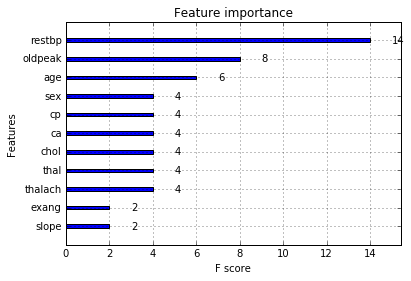

In [19]:
xgb.plot_importance(xgb_model)

To visualize the decision trees that are trained by XGBoost, that is, the XGBoost model you must first install the `graphviz` package. The `graphviz` Python package is installed in the notebook environment by running the following cell: 

In [20]:
!pip install graphviz

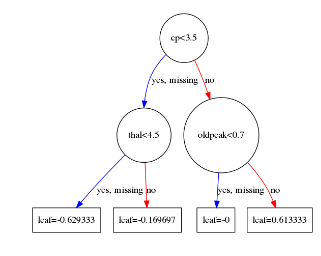

In [21]:
xgb.plot_tree(xgb_model, num_trees=1)

<a id="persistence"></a>
## 4. Persist the model

In this section store the XGBoost model in the Watson Machine Learning repository by using Watson Machine Learning repository service Python client libraries.

In [22]:
from repository.mlrepository import MetaNames
from repository.mlrepository import MetaProps
from repository.mlrepositoryclient import MLRepositoryClient
from repository.mlrepositoryartifact import MLRepositoryArtifact

Authenticate to Watson Machine Learning service on Bluemix. 



**Action**: Put authentication information from your instance of Watson Machine Learning service in the following cell. 
<br>
<br>
**Tip**: service_path, user and password can be found on **Service Credentials** tab of service instance created in Bluemix. If you cannot see **instance_id** field in **Serice Credentials** generate new credentials by pressing **New credential (+)** button. 


In [40]:

wml_credentials = {
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "XXXXXXXXXXXXXX",
  "username": "XXXXXXXXXXX",
  "password": "XXXXXXXXXXX",
  "instance_id": "XXXXXXXXXXXX"
}


In [41]:
ml_repository_client = MLRepositoryClient(wml_credentials['url'])
ml_repository_client.authorize(wml_credentials['username'], wml_credentials['password'])

### 4.1: Save a XGBoost model in the Machine Learning Repository

In this subsection you will learn how to save a model artifact to your Watson Machine Learning instance by using the Watson Machine Learing repository Python client package.

Create an artifact and save it to the machine learning repository by running the following cells:

In [42]:
# Check if props is mandatory
props1 = MetaProps({MetaNames.AUTHOR_NAME:"YOUR_name", MetaNames.AUTHOR_EMAIL:"Your_email@email.com"})

model_artifact = MLRepositoryArtifact(xgb_model, name='XGB_Heart_Disease_Detection', meta_props=props1)

saved_model = ml_repository_client.models.save(model_artifact)


In [ ]:
saved_model_meta = saved_model.meta.get()
pprint.pprint(saved_model_meta)

#### 4.2 Load the Booster from the saved model

In [44]:
saved_model_meta['modelVersionHref']

'https://ibm-watson-ml.mybluemix.net/v2/artifacts/models/17fc44cf-8412-4dde-b8b5-900649c859f2/versions/3b72d3f0-fffc-4606-9f44-b9c235c7bfb5'

In [45]:
loaded_artifact = ml_repository_client.models.version_from_href(saved_model_meta['modelVersionHref'])
loaded_xgb_model = loaded_artifact.model_instance()
print("Type of model: " + str(type(loaded_xgb_model)))

Type of model: <class 'xgboost.core.Booster'>


In [46]:
y_lpredict = loaded_xgb_model.predict(dm_test)
print(y_lpredict)

[ 0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.  0.  1.  0.
  1.  1.  1.  1.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  1.
  0.  1.  1.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  0.
  1.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  1.  0.  0.  1.  0.  0.  0.  1.
  1.  1.  1.  1.  0.  0.  1.  0.  1.]


#### 4.3 Load the Booster as a XGBRegressor
Watson Machine Learning Repository's Python client provides an option to load the XGBoost model i.e Booster as a Scikit-Learn wrapper - XGBRegressor. The command in cell below is used to for this purpose

In [47]:
loaded_artifact = ml_repository_client.models.version_from_href(saved_model_meta['modelVersionHref'])
loaded_xgb_regressor = loaded_artifact.model_instance(as_type="XGBRegressor")

In [48]:
print("Type of model: " + str(type(loaded_xgb_regressor)))

Type of model: <class 'xgboost.sklearn.XGBRegressor'>


In [49]:
y_pred_xgb_reg = loaded_xgb_regressor.predict(heart_test)
print(y_pred_xgb_reg)

[ 0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.  0.  1.  0.
  1.  1.  1.  1.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  1.
  0.  1.  1.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  0.
  1.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  1.  0.  0.  1.  0.  0.  0.  1.
  1.  1.  1.  1.  0.  0.  1.  0.  1.]


<a id="scoring"></a>
## 5. Deploy and score in a Cloud

To access the Watson Machine Learning REST APIs we require a Watson Machine Learning access token. 

To create the WML access token, run the commands in the following cell:

In [50]:
import urllib3, requests, json

headers = urllib3.util.make_headers(basic_auth='{}:{}'.format(wml_credentials['username'], wml_credentials['password']))
url = '{}/v3/identity/token'.format(wml_credentials['url'])
response = requests.get(url, headers=headers)
mltoken = json.loads(response.text).get('token')
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

### 5.1: Deploy the model and create online scoring endpoint

Get the `published_models` URL from instance details.

In [51]:
endpoint_instance = wml_credentials['url'] + "/v3/wml_instances/" + wml_credentials['instance_id']
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken} 

response_get_instance = requests.get(endpoint_instance, headers=header)
print(response_get_instance)
print(response_get_instance.text)

<Response [200]>
{"metadata":{"guid":"ae438838-a71d-4d38-ae20-ac36c0a0384c","url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/ae438838-a71d-4d38-ae20-ac36c0a0384c","created_at":"2017-06-26T11:49:38.710Z","modified_at":"2017-10-05T01:25:51.768Z"},"entity":{"source":"Bluemix","published_models":{"url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/ae438838-a71d-4d38-ae20-ac36c0a0384c/published_models"},"usage":{"expiration_date":"2017-11-01T00:00:00.000Z","computation_time":{"limit":18000,"current":0},"model_count":{"limit":200,"current":16},"prediction_count":{"limit":5000,"current":0},"deployment_count":{"limit":5,"current":3}},"plan_id":"3f6acf43-ede8-413a-ac69-f8af3bb0cbfe","status":"Active","organization_guid":"b547b37d-1aaa-41ac-8ca0-b6ef490ee5dd","region":"us-south","account":{"id":"e2f8f54ce41f76db3f23bca9bc6c7a1f","name":"Mike Sochka's Account","type":"TRIAL"},"owner":{"ibm_id":"50SB5W5H43","email":"msochka@us.ibm.com","user_id":"fd580dc9-39b3-4fad-b508-3c52e8aa

In [52]:
endpoint_published_models = json.loads(response_get_instance.text).get('entity').get('published_models').get('url')
print(endpoint_published_models)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/ae438838-a71d-4d38-ae20-ac36c0a0384c/published_models


Execute the following sample code that uses the `published_models` endpoint to get the deployments URL.

Get the list of published models.

In [ ]:
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

response_get = requests.get(endpoint_published_models, headers=header)
print(response_get)
print(response_get.text)

Get published model deployment URL.

In [54]:
[endpoint_deployments] = [x.get('entity').get('deployments').get('url') for x in json.loads(response_get.text).get('resources') if x.get('metadata').get('guid') == saved_model.uid]

print(endpoint_deployments)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/ae438838-a71d-4d38-ae20-ac36c0a0384c/published_models/17fc44cf-8412-4dde-b8b5-900649c859f2/deployments


#### 5.1.2 Deploy Model

We can now create the online deployment for the published model.

In [55]:
payload_online = {"name": "xgb_heart_disease_v1", "description": "xgb_heart_disease", "type": "online"}
response_online = requests.post(endpoint_deployments, json=payload_online, headers=header)

print(response_online.text)

{"metadata":{"guid":"5861640c-af8a-4d35-aac9-8f2823004571","url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/ae438838-a71d-4d38-ae20-ac36c0a0384c/published_models/17fc44cf-8412-4dde-b8b5-900649c859f2/deployments/5861640c-af8a-4d35-aac9-8f2823004571","created_at":"2017-10-05T01:26:48.097Z","modified_at":"2017-10-05T01:26:49.234Z"},"entity":{"runtime_environment":"python-3.5","name":"xgb_heart_disease_v1","scoring_url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/ae438838-a71d-4d38-ae20-ac36c0a0384c/published_models/17fc44cf-8412-4dde-b8b5-900649c859f2/deployments/5861640c-af8a-4d35-aac9-8f2823004571/online","description":"xgb_heart_disease","published_model":{"author":{"name":"Krishna","email":"krishna@in.ibm.com"},"name":"XGB_Heart_Disease_Detection","url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/ae438838-a71d-4d38-ae20-ac36c0a0384c/published_models/17fc44cf-8412-4dde-b8b5-900649c859f2","guid":"17fc44cf-8412-4dde-b8b5-900649c859f2","created_at":"2017-10-

In [56]:
scoring_url = json.loads(response_online.text).get('entity').get('scoring_url')
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/ae438838-a71d-4d38-ae20-ac36c0a0384c/published_models/17fc44cf-8412-4dde-b8b5-900649c859f2/deployments/5861640c-af8a-4d35-aac9-8f2823004571/online


### 5. 2 Perform Prediction

Now, let us perform predictions on a new set of data using the model that is deployed in the scoring service.

In [57]:
payload_scoring = {
   "values": [[64.0, 1.0, 4.0, 328.0, 263.0, 0.0, 0.0, 105.0, 1.0, 0.2, 2.0, 1.0, 7.0]]
}

response_scoring = requests.post(scoring_url, json=payload_scoring, headers=header)
pprint.pprint(response_scoring.text)

('{\n'
 '  "fields": ["prediction", "probability"],\n'
 '  "values": [[1.0, [-1.467953085899353, 2.4679532051086426]]]\n'
 '}')


The scoring output contains the prediction value and the corresponding margin data.

<a id="summary"></a>
## 6. Summary and next steps     

You successfully completed this notebook! You learned how to use XGBoost machine learning as well as Watson Machine Learning for model creation and deployment. Check out our [Online Documentation](https://console.ng.bluemix.net/docs/services/PredictiveModeling/pm_service_api_spark.html) for more samples, tutorials, documentation, how-tos, and blog posts. 

### Author

**Krishnamurthy Arthanarisamy**, is a senior technical lead in IBM Watson Machine Learning team. Krishna works on developing cloud services that caters to different stages of machine learning and deep learning modeling life cycle. 

Copyright © 2017 IBM. This notebook and its source code are released under the terms of the MIT License.